In [9]:
import os
import polars as pl
import torch

# Huggingface imports
from transformers import (
    AutoTokenizer,
    BertForTokenClassification,
)

# Import own modules
from bert_utils import (
    bio_sequence_labeler,
    get_results,
    display_results,
)


In [10]:
model_path = os.path.join(os.getcwd(), "results", "answer_span_classifier_mbert")
save_path = os.path.join(model_path, "fine_tuned")

In [11]:
# Select device for training
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
if torch.cuda.is_available():
    device = torch.device("cuda")

print(f'Using device: {device}')

Using device: mps


In [12]:
model = BertForTokenClassification.from_pretrained(save_path, num_labels=3)
mbert_tokenizer = AutoTokenizer.from_pretrained(save_path)

In [13]:
df_test_json = pl.read_json("test.json")
df_test_json.head()

question,context,lang,answerable,answer_start,answer,answer_inlang,translation
str,str,str,bool,i64,str,str,str
"""Which company published the vi…","""Hell's Kitchen: The Game is a …","""en""",true,164,"""Ubisoft""","""Ubisoft""","""Which company published the vi…"
"""八一大楼是什么时候完全建成的？""","""The first PLA main office in B…","""zh""",true,584,"""July 1999""","""1999年7月""","""When was the August 1st buildi…"
"""1650ల చివరలో 'Hareskoven'ను ఏ …","""Hareskov was severely damaged …","""te""",true,37,"""the Swedish""","""స్వీడిష్""","""Which country damaged 'Haresko…"
"""ఎముక పురుగులు దేని నుండి ఆహారం…","""Osedax is a genus of deep-sea …","""te""",true,208,"""whale carcasses""","""తిమింగల కళేబరాలు""","""What do boneworms feed on?"""
"""దోసకాయలు ఏ ఖండం నుండి ఉద్భవించ…","""Considered an annual plant, th…","""te""",true,180,"""Asia""","""ఆసియా""","""Which continent did cucumbers …"


### Create label columns
Note that we cut off at 512 tokens. Two instances will have their answer after 512. We do this for simplicity, since the model has 512 token max, and we expect the model to generalize well without these two points.

In [14]:
#df_test_json = df_test_json.with_columns(
#    pl.struct(["question", "context", "answer_start", "answer"]).map_elements(
#        lambda x: bio_sequence_labeler(
#            x["answer_start"],
#            x["answer"],
#            x["question"],
#            x["context"],
#            mbert_tokenizer,
#        ),
#        return_dtype=pl.List(pl.Int8)
#    ).alias("labels")
#)

## Get Confusion Matrix for each language

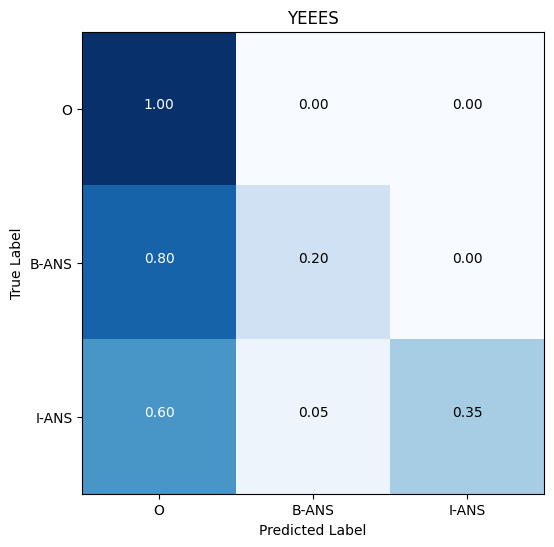

Classification Report:
              precision    recall  f1-score   support

           O       1.00      1.00      1.00      9698
       B-ANS       0.12      0.20      0.15        10
       I-ANS       0.28      0.35      0.31        20

    accuracy                           0.99      9728
   macro avg       0.47      0.52      0.49      9728
weighted avg       1.00      0.99      1.00      9728



In [15]:
df_test_json = df_test_json.with_columns(
    pl.struct(["question", "context", "answer_start", "answer"]).map_elements(
        lambda x: bio_sequence_labeler(x["answer_start"],x["answer"],x["question"],x["context"],
        mbert_tokenizer),
    return_dtype=pl.List(pl.Int8)).alias("labels"))

y_true, y_pred = get_results(model, df_test_json, mbert_tokenizer)
display_results(y_true, y_pred, title="YEEES")

## Get full Confusion Matrix for fully trained model

In [16]:
#y_true, y_pred = get_results(model, df_val, mbert_tokenizer)
#display_results(y_true, y_pred)